In [1]:
import os
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [2]:
from haystack import Pipeline
from haystack.utils.auth import Secret
from haystack.components.builders import PromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

from haystack.components.embedders import OpenAIDocumentEmbedder, OpenAITextEmbedder

In [3]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [4]:
document_store = InMemoryDocumentStore()

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
embedder = OpenAIDocumentEmbedder(model="text-embedding-3-small")
writer = DocumentWriter(document_store=document_store)

indexing = Pipeline()
indexing.add_component("fetcher", fetcher)
indexing.add_component("converter", converter)
indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)

indexing.connect("fetcher.streams", "converter.sources")
indexing.connect("converter", "embedder")
indexing.connect("embedder", "writer")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - embedder: OpenAIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

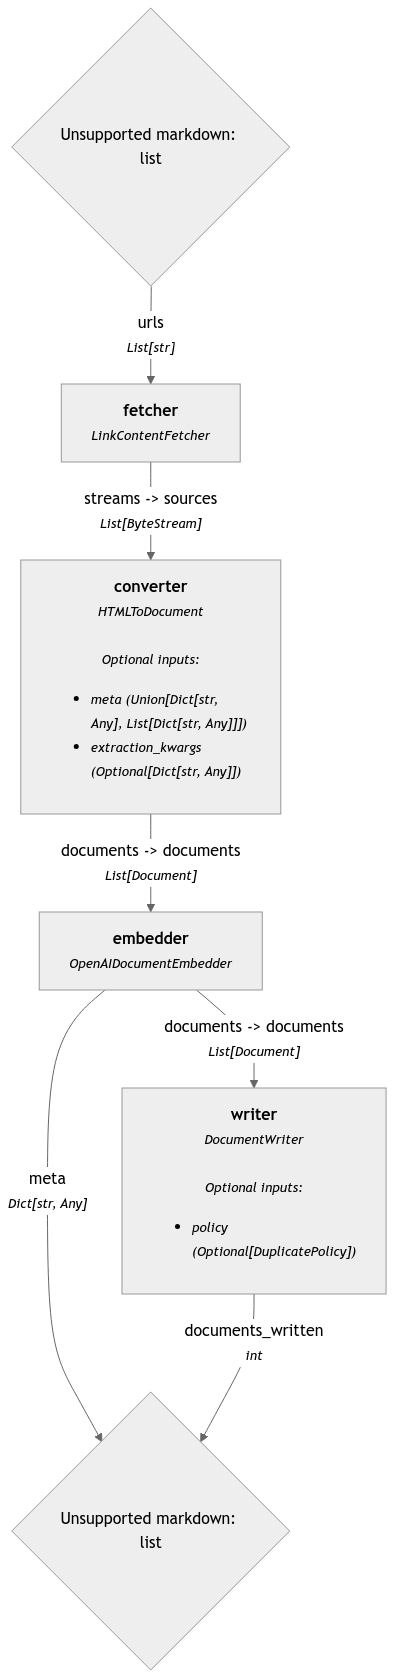

In [5]:
indexing.show()

In [7]:
indexing.run(
    {
        "fetcher": {
            "urls": [
                "https://haystack.deepset.ai/integrations/openai",
                "https://haystack.deepset.ai/integrations/opensearch-document-store",
                "https://haystack.deepset.ai/integrations/mistral",
                "https://haystack.deepset.ai/integrations/huggingface",
            ]
        }
    }
)


Calculating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


{'embedder': {'meta': {'model': 'text-embedding-3-small',
   'usage': {'prompt_tokens': 6455, 'total_tokens': 6455}}},
 'writer': {'documents_written': 4}}

In [9]:
document_store.filter_documents()[3]

Document(id=974651e30f457416c5116aabf8a2b11e74ac650ade5becfc3c4ef7d0ec1154b1, content: 'Integration: Hugging Face
Use Models on Hugging Face with Haystack
Table of Contents
Haystack 2.0
Yo...', meta: {'content_type': 'text/html', 'url': 'https://haystack.deepset.ai/integrations/huggingface'}, embedding: vector of size 1536)

In [8]:
prompt = """
Answer the question based on the provided context.
Context:
{% for doc in documents %}
   {{ doc.content }} 
{% endfor %}
Question: {{ query }}
"""

In [13]:
query_embedder = OpenAITextEmbedder(model="text-embedding-3-small")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
generator = OpenAIGenerator()

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

🚅 Components
  - query_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

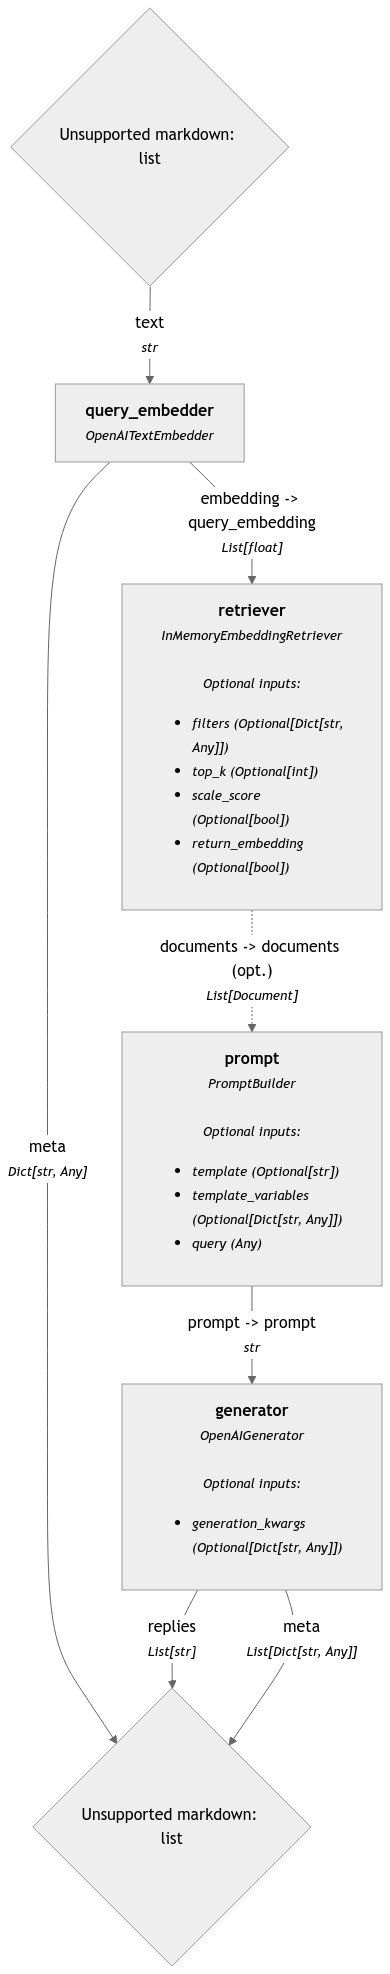

In [14]:
rag.show()

In [15]:
question = "How can I use OpenAI with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question},
    }
)

print(result["generator"]["replies"][0])

To use OpenAI with Haystack, you can create a pipeline that includes a PromptNode component. In the pipeline configuration, specify the model name or path (e.g., "gpt-4"), your OpenAI API key, and a default prompt template for question generation. Ensure that you have documents stored in your OpenSearchDocumentStore related to the topic you want to generate questions about. Run the pipeline with a specific query (e.g., "Pizzas") to generate questions using the OpenAI prompt.


In [22]:
rag

🚅 Components
  - query_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

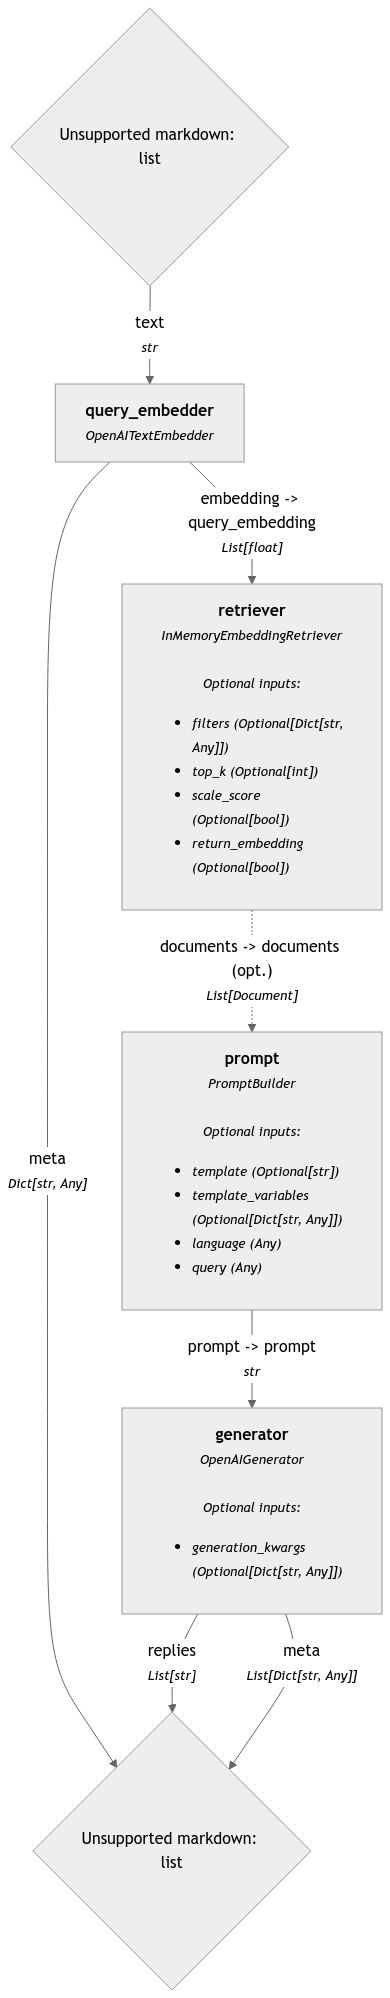

In [23]:
rag.show()

In [18]:
prompt = """
You will be provided some context, followed by the URL that this context comes from.
Answer the question based on the context, and reference the URL from which your answer is generated.
Your answer should be in {{ language }}.
Context:
{% for doc in documents %}
   {{ doc.content }} 
   URL: {{ doc.meta['url']}}
{% endfor %}
Question: {{ query }}
Answer:
"""

In [24]:
question = "How can I use OpenAI with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question, "language": "French"},
    }
)

print(result["generator"]["replies"][0])

Pour utiliser OpenAI avec Haystack, vous pouvez utiliser le prompt "deepset/question-generation" et le node PromptNode dans votre pipeline Haystack pour générer des questions sur les documents récupérés. Vous pouvez ensuite exécuter la requête en utilisant le prompt spécifique comme illustré dans l'exemple fourni. 
URL : https://haystack.deepset.ai/integrations/opensearch-document-store
